In [11]:
import os
import sys
py_files_dir = os.path.abspath("../py_files/")
sys.path.insert(0, py_files_dir)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import instrument_matrices as matrices
import helper_functions as funcs

In [12]:
# Making all plots have a white rather than transparent background
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# Setting Up Polarized Standards Information

In [13]:
# Loading in all data files
csv_directory = '../../data/polarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# List of target names and CSV file paths
targets_info = [
    {"name": "HDE279658", "path": "/home/shared/exoserver/VAMPIRES/20220127/HDE279658/rz_dpp/675nm_em300_10ms_0429_Darks/collapsed/20240222_HDE279658_675_nm_Header_Parameters_R_15_Aperture.csv"},
    {"name": "HD29333", "path": "/home/shared/exoserver/VAMPIRES/20220127/HD29333/rz_dpp/675nm_em300_10ms_0429_Darks/collapsed/20240222_HD29333_675_nm_Header_Parameters_R_15_Aperture.csv"},
    {"name": "HD29835", "path": "/home/shared/exoserver/VAMPIRES/20220127/HD29835/rz_dpp/675nm_em300_10ms_0429_Darks/collapsed/20240222_HD29835_675_nm_Header_Parameters_R_15_Aperture.csv"}
]

# Theoretical target values from Whittet
targets = {
    "HDE279658": {"p_max": (2.81, 0.03), "lam_max": (0.53, 0.01), "k": (0.99, 0.06), 
        "675nm": (2.65, 0.04, 146, 1), "750nm": (2.49, 0.05, 144, 1)},
    "HD29333": {"p_max": (5.25, 0.07), "lam_max": (0.54, 0.02), "k": (0.89, 0.07),
        "675nm": (5.02, 0.1, 71, 1), "750nm": (4.77, 0.13, 71, 1)},
    "HD29835": {"p_max": (4.07, 0.07), "lam_max": (0.5, 0.03), "k": (0.93, 0.11),
        "675nm": (3.72, 0.15, 22, 1), "750nm": (3.49, 0.18, 25, 1)}
}

# Loading Data Files

In [14]:
csv_directory = '../../data/polarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# Load data from all CSV files
all_data = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    df_filtered = df[(df['Q'] != 0) | (df['U'] != 0)]
    all_data = pd.concat([all_data, df])

all_data.reset_index(drop = True, inplace = True)

# Setting Instrument Parameters

In [15]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0.5 # (waves) - assumed to be a perfect mirror for now
epsilon_m3 = 0.0125  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = -2.5  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes
# delta_m3 = 0.5
# epsilon_m3 = 0.0125

# For figuring out the correrct factor for the double diff matrix
double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Test Matrix Inversion of Q and U

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Simulate data
# altitudes = np.linspace(30, 50, 20)
# IMR_angs = funcs.get_imrang_from_alt(altitudes)

# # Setting initial parameters
# injected_aolp = 10
# injected_deg_pol = 10
# injected_stokes_params = funcs.deg_pol_and_aolp_to_stokes(injected_deg_pol, injected_aolp)
# print("Injected Stokes (Q, U): " + str(injected_stokes_params))
# injected_Q = injected_stokes_params[0]
# injected_U = injected_stokes_params[1]

# injected_stokes_vector = np.array([1, injected_Q, injected_U, 0]).reshape(-1, 1)

# model = matrices.full_system_mueller_matrix

# # Initialize lists for storing the results
# Q_list = []
# U_list = []
# pol_list = []
# aolp_list = []
# double_diff_list = []
# final_altitudes = []

# recovered_Q_list = []
# recovered_U_list = []
# recovered_pol_list = []
# recovered_aolp_list = []

# HWP_angs = [0, 45, 22.5, 67.5]
# latitude = 19.8283  # Mauna Kea latitude

# first_rows = []
# double_diff_cycle_list = []

# # Loop through each altitude
# for altitude, IMR_ang in zip(altitudes, IMR_angs):
#     parang = funcs.calculate_parallactic_angle(altitude, latitude)
#     for HWP_ang in HWP_angs:
#         # Calculate full instrument matrices for on-sky
#         these_inst_matrices = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
#             model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor=double_diff_factor)
#         double_diff_matrix = these_inst_matrices[0]

#         # Propagate the injected source through the instrument
#         observed_stokes = double_diff_matrix @ injected_stokes_vector

#         # Extract the double difference and add Gaussian noise
#         double_diff = observed_stokes[0] * (1 + np.random.normal(0, 0.01))
#         double_diff_cycle_list.append(double_diff)
#         double_diff_list.append(double_diff)

#         final_altitudes.append(altitude)

#         # Store the first row elements
#         first_rows.append(double_diff_matrix[0, :3])

#     # Perform matrix inversion after collecting 4 double differences
#     measurement_matrix = np.vstack(first_rows)
#     measurements = np.array(double_diff_cycle_list).reshape(-1, 1)

#     s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

#     Q_recovered = s_HWP[1]
#     U_recovered = s_HWP[2]
#     recovered_Q_list.append(Q_recovered)
#     recovered_U_list.append(U_recovered)

#     pol_recovered, aolp_recovered = funcs.stokes_to_deg_pol_and_aolp(Q_recovered, U_recovered)
#     recovered_pol_list.append(pol_recovered)
#     recovered_aolp_list.append(aolp_recovered)

#     first_rows = []
#     double_diff_cycle_list = []

# # Plotting Degree of Polarization
# plt.figure(figsize=(12, 8))
# plt.plot(altitudes, [injected_deg_pol]*len(altitudes), label='Injected Pol %', linestyle='--', color='blue')
# plt.plot(altitudes, recovered_pol_list, label='Recovered Pol %', linestyle='None', marker='o', color='blue')
# plt.xlabel("Altitude (Degrees)")
# plt.ylabel("Degree of Polarization (%)")
# plt.title("Degree of Polarization on Sky")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.grid(True)
# plt.tight_layout()
# plt.ylim(0, 20)
# plt.show()

# # Plotting Angle of Linear Polarization
# plt.figure(figsize=(12, 8))
# plt.plot(altitudes, [injected_aolp]*len(altitudes), label='Injected AOLP', linestyle='--', color='red')
# plt.plot(altitudes, recovered_aolp_list, label='Recovered AOLP', linestyle='None', marker='o', color='red')
# plt.xlabel("Altitude (Degrees)")
# plt.ylabel("Angle of Linear Polarization (Degrees)")
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.grid(True)
# plt.tight_layout()
# plt.ylim(0, 20)
# plt.show()

# # Plotting Q and U
# # plt.figure(figsize=(12, 8))
# # plt.plot(altitudes, Q_list[:len(altitudes)], label='Injected Q', linestyle='--', color='green')
# # plt.plot(altitudes, recovered_Q_list, label='Recovered Q', linestyle='None', marker='o', color='green')
# # plt.plot(altitudes, U_list[:len(altitudes)], label='Injected U', linestyle='--', color='orange')
# # plt.plot(altitudes, recovered_U_list, label='Recovered U', linestyle='None', marker='o', color='orange')
# # plt.xlabel("Altitude (Degrees)")
# # plt.ylabel("Stokes Parameters (Q/U)")
# # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# # plt.grid(True)
# # plt.tight_layout()
# # plt.show()


# Forward Modelled Q and U at the Detectors

Object Name: HDE279658
Injected Stokes (Q, U): (0.009927074725521666, -0.024570372146019866)
Object Name: HD29333
Injected Stokes (Q, U): (-0.03955813983105744, 0.03090620606134805)
Object Name: HD29835
Injected Stokes (Q, U): (0.026759440572597826, 0.025841291381074702)


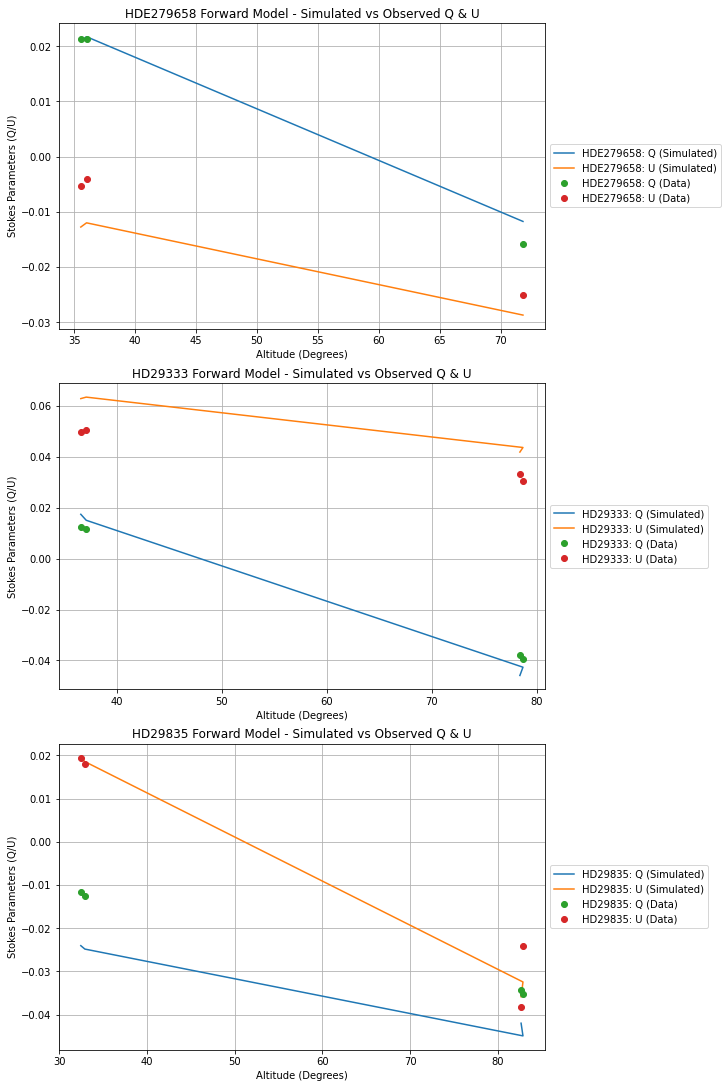

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Setting initial parameters
model = matrices.full_system_mueller_matrix

# Initialize lists for storing the results
Q_list = []
U_list = []
pol_list = []
aolp_list = []
double_diff_list = []
final_altitudes = []

HWP_angs = [0, 45, 22.5, 67.5]

# Example usage
latitude = 19.8283  # Mauna Kea latitude
longitude = -155.4783  # Mauna Kea longitude
elevation = 4205  # Mauna Kea elevation in meters
ra = 120  # Example Right Ascension in degrees
dec = 20  # Example Declination in degrees

# Altitudes and corresponding IMR angles for
# simulated_altitudes = np.linspace(30, 80, 50)
# latitudes = np.array([19.8283] * len(simulated_altitudes))  # Mauna Kea latitude
# IMR_angs = funcs.get_imrang_from_alt(simulated_altitudes)

# For debugging all these values
# print("IMR Angs Length: " + str(len(IMR_angs)))
# print("IMR Angs: " + str(IMR_angs))
# print("Simulated Altitudes Length: " + str(len(simulated_altitudes)))
# print("Parangs Length: " + str(len(parangs)))
# print("Parallactic Angles: " + str(parangs))


# For saving the simulated data
simulated_Q_list = []
simulated_U_list = []

data_dir = "../../data/polarized/csv/"

# Theoretical target values from Whittet
targets = {
    "HDE279658": {"p_max": (2.81, 0.03), "lam_max": (0.53, 0.01), "k": (0.99, 0.06), 
        "675nm": (2.65, 0.04, 146, 1), "750nm": (2.49, 0.05, 144, 1), "path": "20240222_HDE279658_675_nm_Header_Parameters_R_15_Aperture.csv"},
    "HD29333": {"p_max": (5.25, 0.07), "lam_max": (0.54, 0.02), "k": (0.89, 0.07),
         "675nm": (5.02, 0.1, 71, 1), "750nm": (4.77, 0.13, 71, 1), "path": "20240222_HD29333_675_nm_Header_Parameters_R_15_Aperture.csv"},
    "HD29835": {"p_max": (4.07, 0.07), "lam_max": (0.5, 0.03), "k": (0.93, 0.11),
         "675nm": (3.72, 0.15, 22, 1), "750nm": (3.49, 0.18, 25, 1), "path": "20240222_HD29835_675_nm_Header_Parameters_R_15_Aperture.csv"}
}

# Putting several plots on one axis
fig, axs = plt.subplots(len(targets), 1, figsize=(10, 15), constrained_layout=True, facecolor='white', edgecolor='white')

for ax, (obj_name, obj_data) in zip(axs, targets.items()):
    print("Object Name: " + obj_name)
    injected_deg_pol = obj_data["675nm"][0]
    injected_aolp = obj_data["675nm"][2]
    injected_stokes_params = funcs.deg_pol_and_aolp_to_stokes(injected_deg_pol, injected_aolp)
    print("Injected Stokes (Q, U): " + str(injected_stokes_params))
    injected_Q = injected_stokes_params[0]
    injected_U = injected_stokes_params[1]

    injected_stokes_vector = np.array([1, injected_Q, injected_U, 0]).reshape(-1, 1)

    full_file_path = data_dir + obj_data["path"]
    df = pd.read_csv(full_file_path)
    df_filtered = df[(df['Q'] != 0) | (df['U'] != 0)]
    data_Q = df_filtered['Q'].values
    data_U = df_filtered['U'].values
    data_altitudes = df_filtered['ALTITUDE'].values
    parangs = df_filtered['PA'].values
    IMR_angs = df_filtered["D_IMRANG"].values

    # Loop through each altitude
    for i, altitude in enumerate(data_altitudes):
        these_inst_matrices = matrices.full_system_mueller_matrix_QU(
            model, fixed_params, parangs[i], altitude, IMR_angs[i], 
            factor=double_diff_factor)
        Q_matrix = these_inst_matrices[0]
        U_matrix = these_inst_matrices[1]

        # Propagate the injected source through the instrument
        simulated_Q = (Q_matrix @ injected_stokes_vector)[0][0]
        simulated_U = (U_matrix @ injected_stokes_vector)[0][0]

        # For debugging the simulated values
        # print("Simulated Q: " + str(simulated_Q))
        # print("Simulated U: " + str(simulated_U))

        simulated_Q_list.append(simulated_Q)
        simulated_U_list.append(simulated_U)

    simulated_Q_list = np.array(simulated_Q_list)
    simulated_U_list = np.array(simulated_U_list)
    data_Q = np.array(data_Q)
    data_U = np.array(data_U)

    simulated_deg_pol_list, simulated_aolp_list = \
        funcs.stokes_to_deg_pol_and_aolp(simulated_Q_list, simulated_U_list)
    data_deg_pol_list, data_aolp_list = \
        funcs.stokes_to_deg_pol_and_aolp(data_Q, data_U)

    # Plotting Q and U
    ax.plot(data_altitudes, simulated_Q_list, label = obj_name + ": Q (Simulated)")
    ax.plot(data_altitudes, simulated_U_list, label = obj_name + ": U (Simulated)")
    ax.plot(data_altitudes, data_Q, marker = "o", label = obj_name + ": Q (Data)", linestyle = "None")
    ax.plot(data_altitudes, data_U, marker = "o", label = obj_name + ": U (Data)", linestyle = "None")
    ax.set_title(obj_name + " Forward Model - Simulated vs Observed Q & U")
    ax.set_xlabel("Altitude (Degrees)")
    ax.set_ylabel("Stokes Parameters (Q/U)")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True)
    ax.set_facecolor('white')

    # Plotting %Pol
    # ax.plot(data_altitudes, simulated_deg_pol_list, label = obj_name + ": %Pol (Simulated)")
    # ax.plot(data_altitudes, data_deg_pol_list, marker = "o", label = obj_name + ": %Pol (Data)", linestyle = "None")
    # ax.set_title(obj_name + " Forward Model - Simulated vs Observed %Pol")
    # ax.set_xlabel("Altitude (Degrees)")
    # ax.set_ylabel("%Pol")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.grid(True)
    # ax.set_facecolor('white')

    # Plotting AOLP
    # ax.plot(data_altitudes, simulated_aolp_list, label = obj_name + ": AOLP (Simulated)")
    # ax.plot(data_altitudes, data_aolp_list, marker = "o", label = obj_name + ": AOLP (Data)", linestyle = "None")
    # ax.set_title(obj_name + " Forward Model - Simulated vs Observed AOLP")
    # ax.set_xlabel("Altitude (Degrees)")
    # ax.set_ylabel("AOLP")
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.grid(True)
    # ax.set_facecolor('white')

    simulated_Q_list = []
    simulated_U_list = []

plt.show()


# Testing Coordinate Functions

HD29835 Coordinates: RA: 4:43:05.03612015, Dec: 26.24307215362 deg
[-149.62672964 -159.10558161 -169.81455929  178.77548151  167.45382596
  156.97451284  147.79109157  140.01541519  133.53753579  128.15871622
  123.67234607  119.89778171  116.68839802  113.92903106  111.53035126
  109.42319496  107.5538048   105.88011024  104.36891082  102.99376973
  101.73344324  100.57070685   99.49147323   98.48412483   97.53900491
   96.64802627   95.80436789   95.00223789   94.23668682   93.50345936
   92.79887589   92.11973696   91.46324595   90.82694592   90.20866776
   89.60648741   89.01869031   88.44374173   87.88026185   87.3270048
   86.78284083   86.24674123   85.71776532   85.19504941   84.67779718
   84.1652714    83.65678675   83.1517035    82.64942206   82.14937809]


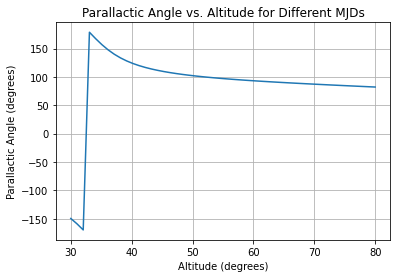

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy import units as u

def calculate_hour_angle(ra, lst):
    """
    Calculate the hour angle from right ascension and local sidereal time.

    Args:
        ra (float): Right Ascension in degrees.
        lst (float): Local Sidereal Time in degrees.

    Returns:
        float: Hour Angle in degrees.
    """
    ha = lst - ra
    if ha < 0:
        ha += 360
    elif ha >= 360:
        ha -= 360
    return ha

def parallactic_angle(ha, dec, lat):
    """
    Calculate the parallactic angle using the hour angle and declination.

    Args:
        ha (float): Hour angle in degrees.
        dec (float): Declination in degrees.
        lat (float): Latitude of the observation site in degrees.

    Returns:
        float: Parallactic angle in degrees.
    """
    ha_rad = np.radians(ha)
    dec_rad = np.radians(dec)
    lat_rad = np.radians(lat)
    pa = np.arctan2(np.sin(ha_rad), np.tan(lat_rad) * np.cos(dec_rad) - np.sin(dec_rad) * np.cos(ha_rad))
    return np.degrees(pa)

def calculate_parallactic_angles(latitude, longitude, target_name, mjds):
    """
    Calculate the parallactic angle for a range of altitudes over a range of MJDs.

    Args:
        latitude (float): Latitude of the observation site in degrees.
        longitude (float): Longitude of the observation site in degrees.
        elevation (float): Elevation of the observation site in meters.
        target_name (str): Name of the target.
        altitudes (array-like): Range of altitudes in degrees.
        mjd_start (float): Start MJD of the observation.
        mjd_end (float): End MJD of the observation.
        num_steps (int): Number of time steps between the start and end MJD.

    Returns:
        dict: Dictionary with altitude as keys and lists of parallactic angles for the given MJDs as values.
    """
    # Generate the range of MJDs
    parallactic_angles = np.zeros(np.shape(mjds))

    # Get the target coordinates
    target = SkyCoord.from_name(target_name)
    
    # Print RA in hours
    ra_hours = target.ra.to_string(unit=u.hour, sep=':')
    print(f"{target_name} Coordinates: RA: {ra_hours}, Dec: {target.dec}")
    
    # Calculate parallactic angles for each MJD
    for i, mjd in enumerate(mjds):
        # Create a Time object from MJD
        observation_time = Time(mjd, format='mjd')
        
        # Calculate LST (Local Sidereal Time)
        lst = observation_time.sidereal_time('apparent', longitude).deg

        # Calculate Hour Angle (HA)
        ha = calculate_hour_angle(target.ra.deg, lst)

        pa = parallactic_angle(ha, target.dec.deg, latitude)
        parallactic_angles[i] = pa

    return parallactic_angles

# Observartory Information
latitude = 19.8283  # Mauna Kea latitude
longitude = -155.4783  # Mauna Kea longitude
elevation = 4205  # Mauna Kea elevation in meters

target_name = "HD29835"  # Target name
num_points = 50

mjd_start = 59607.26332
mjd_end = 59607.44889
altitudes = np.linspace(30, 80, num_points)  # Range of altitudes for testing
mjds = np.linspace(mjd_start, mjd_end, num_points)  # Range of MJDs for testing

parallactic_angles = calculate_parallactic_angles(latitude, longitude, 
    target_name, mjds)

print(parallactic_angles)

plt.plot(altitudes, parallactic_angles)
plt.xlabel('Altitude (degrees)')
plt.ylabel('Parallactic Angle (degrees)')
plt.title('Parallactic Angle vs. Altitude for Different MJDs')
plt.grid(True)
plt.show()

In [19]:
import numpy as np
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy import units as u

def calculate_hour_angle(ra, lst):
    """
    Calculate the hour angle from right ascension and local sidereal time.

    Args:
        ra (float): Right Ascension in degrees.
        lst (float): Local Sidereal Time in degrees.

    Returns:
        float: Hour Angle in degrees.
    """
    ha = lst - ra
    if ha < 0:
        ha += 360
    elif ha >= 360:
        ha -= 360
    return ha

def parallactic_angle(ha, dec, lat):
    """
    Calculate the parallactic angle using the hour angle and declination.

    Args:
        ha (float): Hour angle in degrees.
        dec (float): Declination in degrees.
        lat (float): Latitude of the observation site in degrees.

    Returns:
        float: Parallactic angle in degrees.
    """
    ha_rad = np.radians(ha)
    dec_rad = np.radians(dec)
    lat_rad = np.radians(lat)
    pa = np.arctan2(np.sin(ha_rad), np.tan(lat_rad) * np.cos(dec_rad) - np.sin(dec_rad) * np.cos(ha_rad))
    return np.degrees(pa)

def calculate_parallactic_angle(latitude, longitude, elevation, target_name, altitudes, mjd):
    """
    Calculate the parallactic angle for a range of altitudes at a specific date and time.

    Args:
        latitude (float): Latitude of the observation site in degrees.
        longitude (float): Longitude of the observation site in degrees.
        elevation (float): Elevation of the observation site in meters.
        target_name (str): Name of the target.
        altitudes (array-like): Range of altitudes in degrees.
        mjd (float): Modified Julian Date of the observation.

    Returns:
        list: Parallactic angles for the given altitudes.
    """
    # Create a Time object from MJD
    observation_time = Time(mjd, format='mjd')

    # Set the location
    location = EarthLocation(lat=latitude*u.deg, lon=longitude*u.deg, height=elevation*u.m)

    # Calculate LST (Local Sidereal Time)
    lst = observation_time.sidereal_time('apparent', longitude).deg

    # Get the target coordinates
    target = SkyCoord.from_name(target_name)
    
    # Print RA in hours
    ra_hours = target.ra.to_string(unit=u.hour, sep=':')
    print(f"{target_name} Coordinates: RA: {ra_hours}, Dec: {target.dec}")

    # Calculate Hour Angle (HA)
    ha = calculate_hour_angle(target.ra.deg, lst)

    # Calculate parallactic angle
    parallactic_angles = []
    for alt in altitudes:
        pa = parallactic_angle(ha, target.dec.deg, latitude)
        parallactic_angles.append(pa)

    return parallactic_angles

# Example usage
latitude = 19.8283  # Mauna Kea latitude
longitude = -155.4783  # Mauna Kea longitude
elevation = 4205  # Mauna Kea elevation in meters
target_name = "HD29835"  # Target name
altitude = [82.45033] # Single altitude for testing
mjd = 59607.26332  # Modified Julian Date

parallactic_angles = calculate_parallactic_angle(latitude, longitude, elevation, target_name, altitude, mjd)
for alt, pa in zip(altitude, parallactic_angles):
    print(f"Altitude: {alt:.5f} degrees, Parallactic Angle: {pa:.7f} degrees")


HD29835 Coordinates: RA: 4:43:05.03612015, Dec: 26.24307215362 deg
Altitude: 82.45033 degrees, Parallactic Angle: -149.6267296 degrees


In [20]:
print(np.linspace(80, 30, 50))

[80.         78.97959184 77.95918367 76.93877551 75.91836735 74.89795918
 73.87755102 72.85714286 71.83673469 70.81632653 69.79591837 68.7755102
 67.75510204 66.73469388 65.71428571 64.69387755 63.67346939 62.65306122
 61.63265306 60.6122449  59.59183673 58.57142857 57.55102041 56.53061224
 55.51020408 54.48979592 53.46938776 52.44897959 51.42857143 50.40816327
 49.3877551  48.36734694 47.34693878 46.32653061 45.30612245 44.28571429
 43.26530612 42.24489796 41.2244898  40.20408163 39.18367347 38.16326531
 37.14285714 36.12244898 35.10204082 34.08163265 33.06122449 32.04081633
 31.02040816 30.        ]
